### Lead Classification Model

### Problem Statement

<b>Data</b> : Marekting Data of a Portuguese Bank

<b>Problem Statement</b> : 

- The dataset in focus is the Mareting Dataset of a Portugese Bank consisting information of its customers demographic, past     marekting results, customer contact information and results of current marekting campaign. The dataset yes class corresponds     to customer being converted and no class corresponds to customer being non - convereted.

- The problem is to identify if the future customer will convert or not and to seggregate customers into buckets Hot, Warm & 
    Cold leads to achieve even better taregting.

   | True Class      | Positive | Negative |
   | ----------      | -------- | -------- |
   |Predicted Class  |          |          |
   | Positive        |          | Cost_1   |
   | Negative        | Cost_2   |          |
   

- The Total cost of a prediction model is the sum of number of instances multiplied by "Cost_1" plus the number of instances     of multiplied by "Cost_2", resulting in Total_Cost. In this case the Cost_1 refers to the amount marekting spend on a           customer lead who has no chance of getting converted in the future and the amount of marketing spend on customer which was     not required

- <b>Total_Cost</b> = Cost_1 * Instances + Cost_2 * Instances

- From the above scenario we need to reduce both False Positive and False Negative as we have to avoid spending money on customers unlikely to be converted as well we want to spend money on customers who could be converted. This also depends on the marketing money that we have decided to spend in the first place.

### Challenges and other Objectives

- Need to handle imbalance of Targte Variable
- Need to get good Precision, Recall and F1 Score
- Accuracy can be mediocre
- Misclassification leads to wrong allotment of Marketing Funds

### Benefits of this Project

- Determine Appropriate Target Customer Based Marketing Campaign
- Allocation Cost to Marketing Campaign as per Target Leads
- Determing New Products
- Saving on Marketing Costs

#### Importing Required Libraries

In [335]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
from pathlib import Path as Path
import os
import psycopg2 as ps
import pandas as pd
import pymysql
from matplotlib.pyplot import figure
pd.set_option('display.float_format', '{:.2f}'.format)


In [89]:
pip install imblearn

### Exploratory Data Analysis

#### Read Data

In [90]:
#Reading CSV File
df = pd.read_csv("bank-additional-full.csv", sep=";")

#### Connecting to SQL

In [276]:
#Connecting to SQL Lite Database
Path('sys.db').touch()
leads_conn = sqlite3.connect('sys.db')
leads_cursor = leads_conn.cursor()

In [277]:
#Sending records to SQL Table
df.to_sql('Leads_Table', con = leads_conn, if_exists = 'append', chunksize = 1000, index=False)

41188

#### Count of Target Variable

In [278]:
#Count of Total Leads who got converted and who did not get converted
Total_Outcome = pd.read_sql('''SELECT y,Count(y)
                               from Leads_Table
                               Group By y''', leads_conn)

In [11]:
Total_Outcome

,y,Count(y)
0,no,255836
1,yes,32480


#### Count Outcome of old Campaign

In [279]:
#Count of leads who had previously got converted
Outcome_Previous = pd.read_sql('''SELECT poutcome, (Count(poutcome))*100/sum(Count(poutcome)) OVER() as Sucess_pct
                                          from Leads_Table
                                          Group By poutcome''', leads_conn)

In [280]:
Outcome_Previous

,poutcome,Sucess_pct
0,failure,10
1,nonexistent,86
2,success,3


According to the above Percentage Values we do not have data for more than 80% of Customers. Therefore we will not be considering poutcome column in our further analysis. We will be dropping this column in model building.

#### Count No of Contact Days for all Leads

In [281]:
#Count of Unique values of count of last contacted days
Unique_p_values = pd.read_sql('''SELECT  pdays, count(pdays), (Count(pdays))*100/sum(Count(pdays)) OVER() as Sucess_pct
                                  from Leads_Table
                                  group by pdays''', leads_conn)

In [282]:
Unique_p_values

,pdays,count(pdays),Sucess_pct
0,0,135,0
1,1,234,0
2,2,549,0
3,3,3951,1
4,4,1062,0
5,5,414,0
6,6,3708,1
7,7,540,0
8,8,162,0
9,9,576,0


From the Above Table we can see that more than 96% of our customers had been contacted over 999 days and above. Hence we do not have significant data to include this in our final analysis. We have decided to drop this column in model building.

Since we have discarded two columns poutcome and pdays and we have kept duration column aside for now. Let us perform numerical, graphical and statistical analysis on remaining columns

#### Dropping Unncessary columns

In [283]:
#Dropping certain columns
df.drop(['previous','poutcome','duration','pdays'], axis=1, inplace=True)

#### Target Variable Percent for all columns

In [284]:
#Count of converted/not converted values in Tabular Format for Categorical and Numerical Columns
def count(data):
    for i in data:
        print("**********",i,"*************")
        each_Total = data.groupby(data[i]).y.count()
        Per_Sum = (each_Total/sum(each_Total))*100
        print(Per_Sum )

#### What is the total count of coverted vs not converted leads ? 

In [131]:
df_count = df.groupby(['y'])['y'].count()
print("The number of people in each job category are : \n {} ". format(df_count))

The number of people in each job category are : 
 y
no     36548
yes     4640
Name: y, dtype: int64 


#### What is the total no of leads converted leads in all different categories ?

In [196]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']

In [197]:
def converted_leads(df, cat_cols):
    for i in cat_cols:
        if i in df:
            df_converted = df.query("y == 'yes'").groupby([i])['y'].count().sort_values(ascending=False)
            print("The number of converted leads in this category are : \n {} ". format(df_converted))
            print("---------------------------------------------------")

In [198]:
converted_leads(df,cat_features)

The number of converted leads in this category are : 
 job
admin.           1352
technician        730
blue-collar       638
retired           434
management        328
services          323
student           275
self-employed     149
unemployed        144
entrepreneur      124
housemaid         106
unknown            37
Name: y, dtype: int64 
---------------------------------------------------
The number of converted leads in this category are : 
 marital
married     2532
single      1620
divorced     476
unknown       12
Name: y, dtype: int64 
---------------------------------------------------
The number of converted leads in this category are : 
 education
university.degree      1670
high.school            1031
professional.course     595
basic.9y                473
basic.4y                428
unknown                 251
basic.6y                188
illiterate                4
Name: y, dtype: int64 
---------------------------------------------------
The number of converted leads in

#### What is the total percentage of converted leads in all categories ?

In [293]:
def converted_leads(df, cat_cols):
    for i in cat_cols:
        if i in df:
            df_converted = df.query("y == 'yes'").groupby([i])['y'].count().sort_values(ascending=False)
            df_converted_total = df_converted.sum()
            pct = df.query("y == 'yes'").groupby([i])['y'].count().sort_values(ascending=False) / df_converted_total
            print("The number of converted leads in this category are : \n {} ". format(pct))
            print("---------------------------------------------------")

In [294]:
converted_leads(df, cat_features)

The number of converted leads in this category are : 
 job
admin.           0.291379
technician       0.157328
blue-collar      0.137500
retired          0.093534
management       0.070690
services         0.069612
student          0.059267
self-employed    0.032112
unemployed       0.031034
entrepreneur     0.026724
housemaid        0.022845
unknown          0.007974
Name: y, dtype: float64 
---------------------------------------------------
The number of converted leads in this category are : 
 marital
married     0.545690
single      0.349138
divorced    0.102586
unknown     0.002586
Name: y, dtype: float64 
---------------------------------------------------
The number of converted leads in this category are : 
 education
university.degree      0.359914
high.school            0.222198
professional.course    0.128233
basic.9y               0.101940
basic.4y               0.092241
unknown                0.054095
basic.6y               0.040517
illiterate             0.000862
Name: y

#### Find total converted leads pertaining to job, marital and education ?

In [213]:
df_custinfo = df.query("y == 'yes'").groupby(['job','marital','education','housing','loan','contact','month','day_of_week'])['y'].count().sort_values(ascending=False)

In [267]:
df_custinfo.sum()

4640

In [273]:
((df.query("y == 'yes'").groupby(['job','marital','education','housing','loan','contact','month','day_of_week'])['y'].count().sort_values(ascending=False)/df_custinfo.sum())*100).round(2)

job           marital  education          housing  loan  contact   month  day_of_week
admin.        single   university.degree  yes      no    cellular  apr    thu            0.30
              married  university.degree  yes      no    cellular  aug    wed            0.24
                                                                          tue            0.19
              single   university.degree  yes      no    cellular  aug    wed            0.19
              married  university.degree  yes      no    cellular  apr    thu            0.19
                                                                                         ... 
entrepreneur  married  university.degree  yes      no    cellular  apr    fri            0.02
                                                                   aug    fri            0.02
                                                                   jul    mon            0.02
                                                                    

#### Distribution Plot for Categorical Features with respect to Target Variable

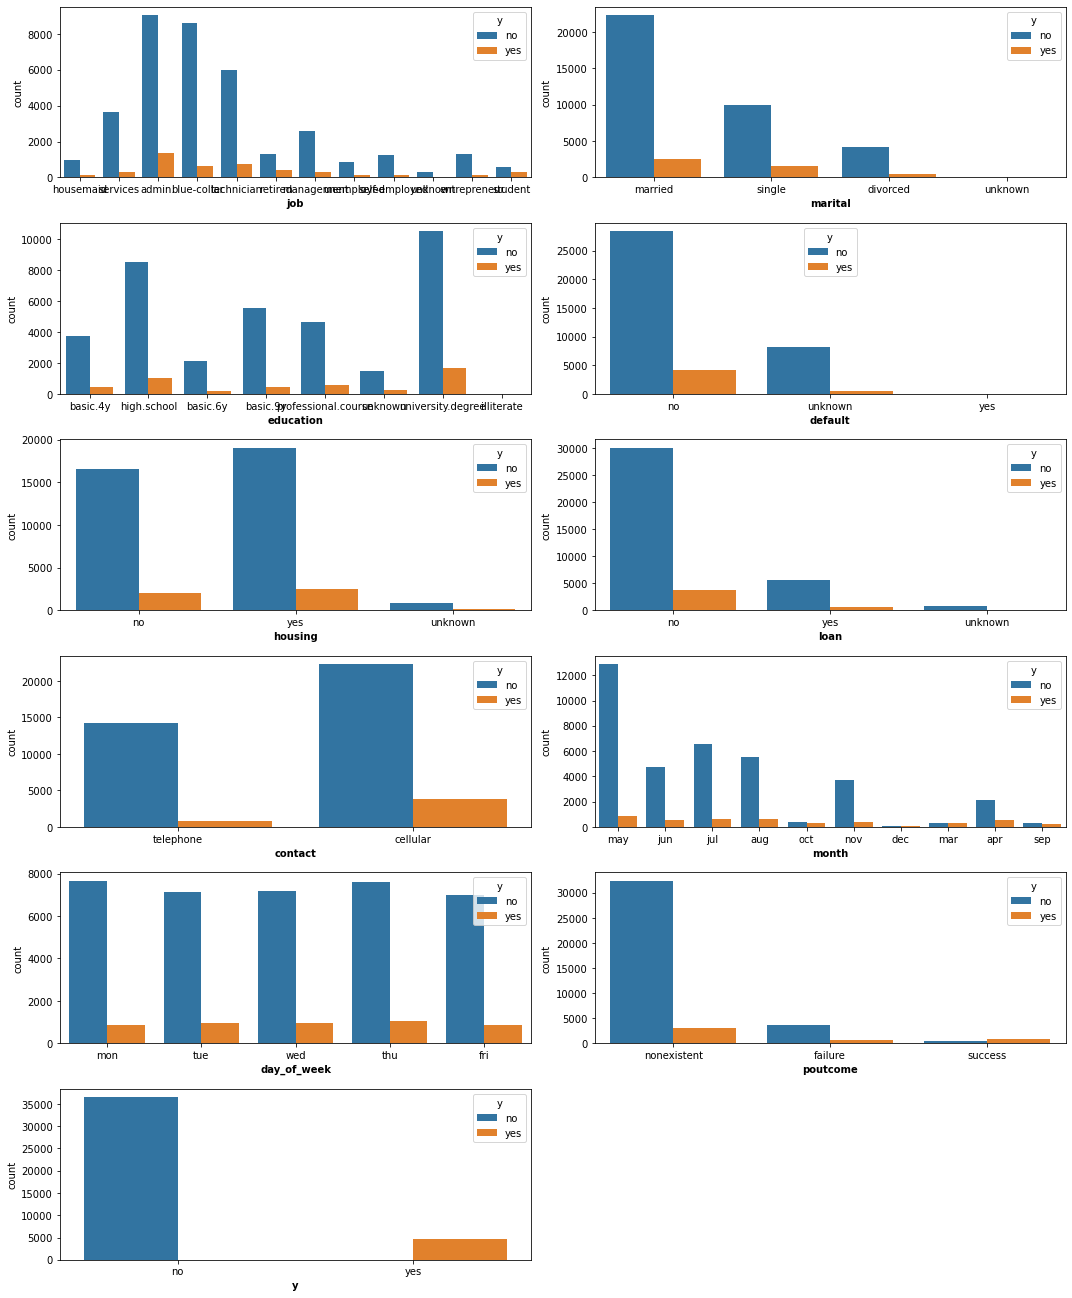

In [10]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']

plt.figure(figsize=(15, 150))
for i, col in enumerate(cat_features):
    plt.subplot(50,2,i+1)
    sns.countplot(x=df[col], hue=df['y'])
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

#### Distribution Plot for Numerical Features

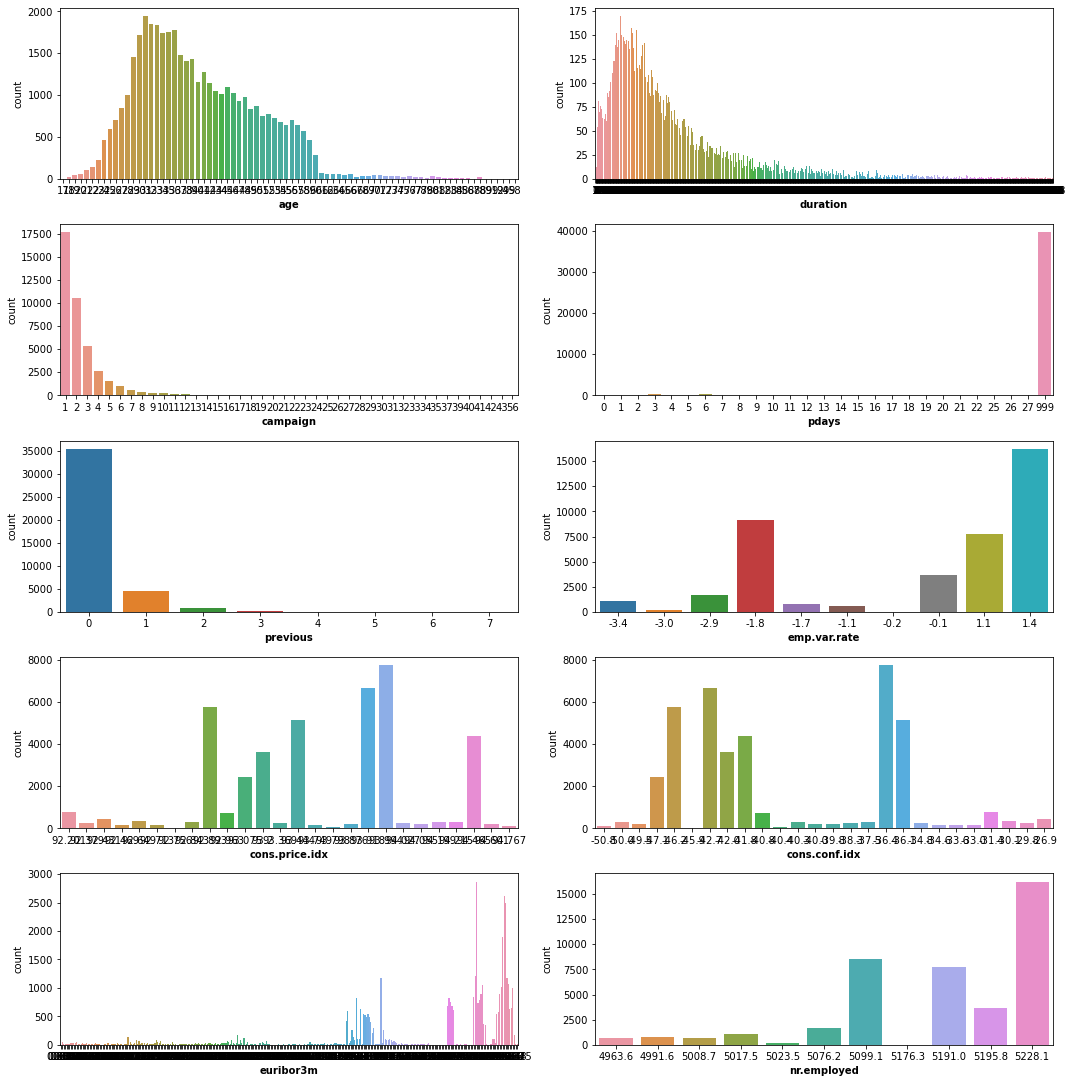

In [12]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 150))
for i, col in enumerate(num_features):
    plt.subplot(50,2,i+1)
    sns.countplot(x=df[col])
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

#### Box plot for Numerical Features

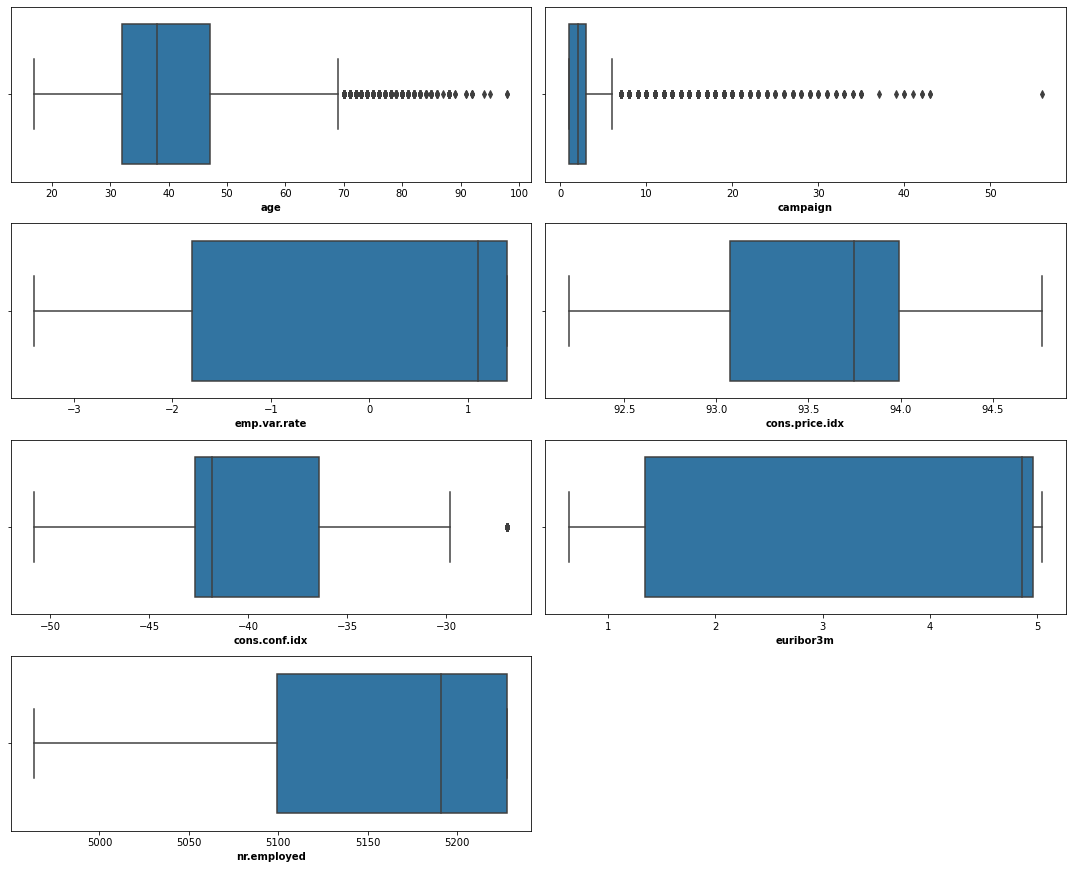

In [314]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 150))
for i, col in enumerate(num_features):
    plt.subplot(50,2,i+1)
    sns.boxplot(x=df[col])
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

#### Violin Plot for all Numerical Features

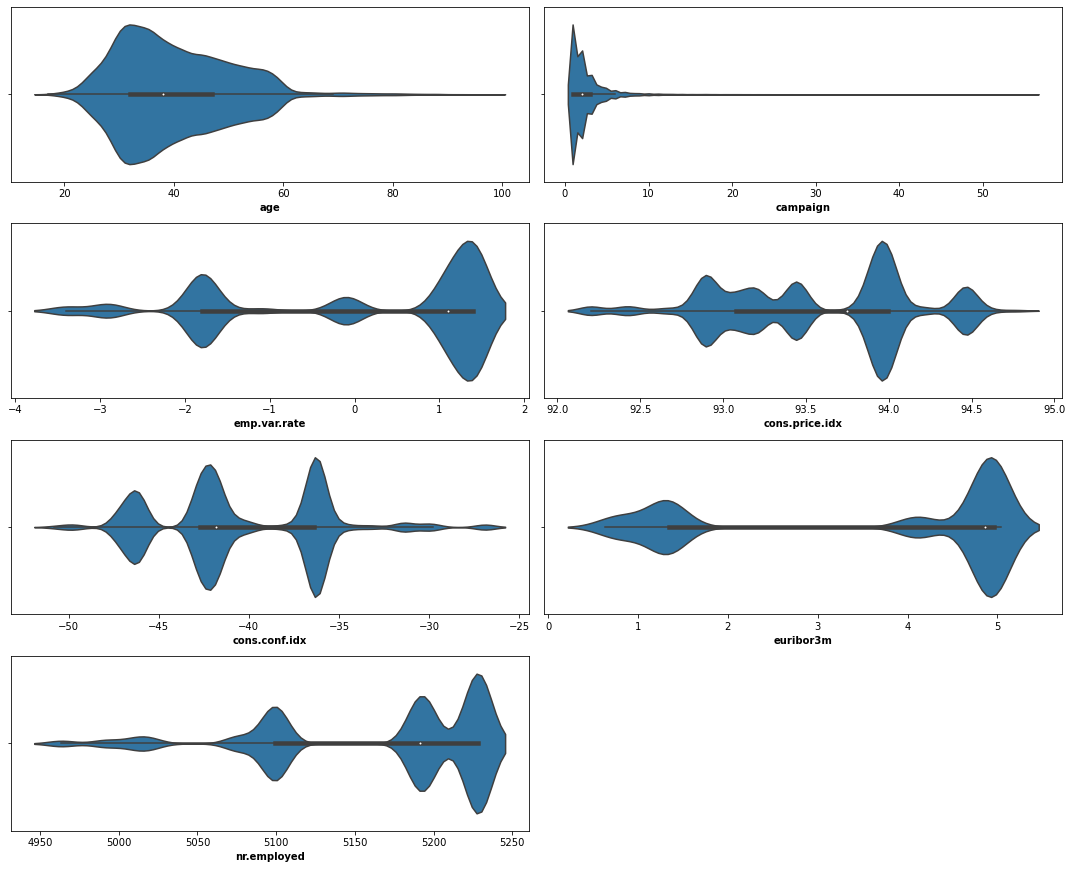

In [312]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 150))
for i, col in enumerate(num_features):
    plt.subplot(50,2,i+1)
    sns.violinplot(x=df[col])
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

#### QQ Plot for all numerical features

In [306]:
import statsmodels.api as sm
from scipy import stats

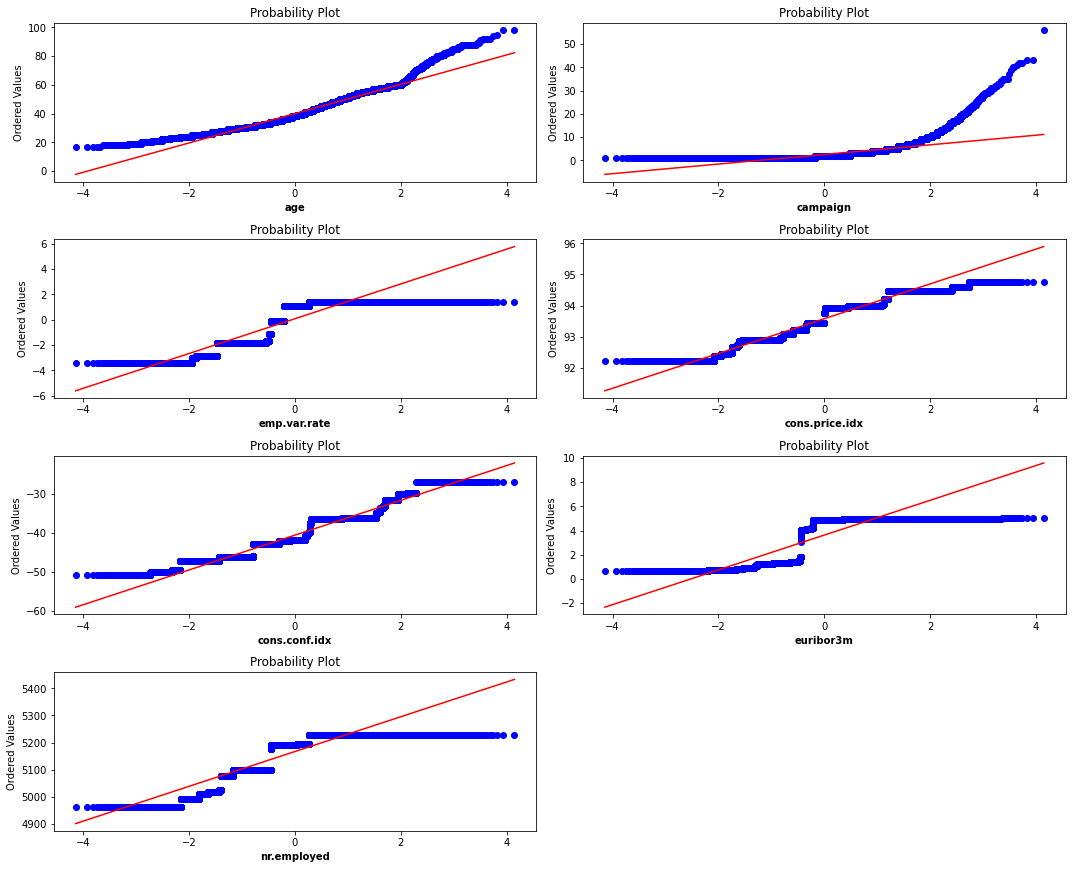

In [307]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 150))
for i, col in enumerate(num_features):
    plt.subplot(50,2,i+1)
    stats.probplot(df[col], plot=sns.mpl.pyplot)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

#### Observations

1. We can see that the numerical features do not have normal distribution. They are postively skewed, negatively skewed and bimodals respectively
2. There are outliers in the datasets which is visible from the violin and box plots respectively

#### Descriptive Statistics for Numerical Columns

In [414]:
#Statistical Vlaues for all numerical columns
df.describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Pearson Correlation for Numerical Features and Heatmap

<AxesSubplot:>

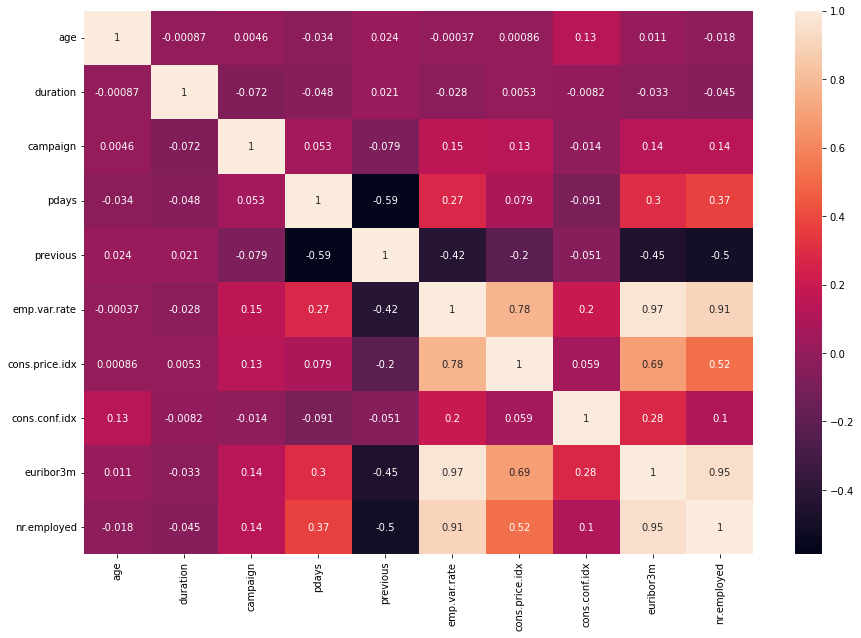

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)

#### Top 20 Converted Leads for Contact Type, Month and  Day of the Week

In [420]:
#Count of Converted leads for all Permutations of Distinct Contact, Distinct Month, Distrinc day_of_week
count_contact = pd.read_sql('''SELECT contact, month, day_of_week, COUNT(y) AS Total, count(y)*100/sum(count(y)) over() as Scuess_PCT 
                           FROM Leads_Table
                           where y='yes'
                           GROUP BY contact, month, day_of_week''', leads_conn)

In [421]:
count_contact.sort_values(['Total'], ascending=False).head(20)

,contact,month,day_of_week,Total,Scuess_PCT
2,cellular,apr,thu,1302,4
31,cellular,may,mon,888,3
8,cellular,aug,tue,846,3
9,cellular,aug,wed,816,2
17,cellular,jul,thu,774,2
30,cellular,may,fri,762,2
34,cellular,may,wed,744,2
7,cellular,aug,thu,744,2
18,cellular,jul,tue,732,2
19,cellular,jul,wed,726,2


#### Top 20 converted Leads for Type of Job, Marital Status and Education Taken

In [422]:
#count of converted contacts for all permutations of Distinct Job, Distinct Marital, Distinct Education 
count_info = pd.read_sql('''SELECT job, marital, education, COUNT(y) AS Total, count(y)*100/sum(count(y)) over() as Scuess_PCT 
                           FROM Leads_Table
                           where y='yes'
                           GROUP BY job, marital, education''', leads_conn)

In [423]:
count_info.sort_values(['Total'], ascending=False).head(20)

,job,marital,education,Total,Scuess_PCT
11,admin.,married,university.degree,2316,8
17,admin.,single,university.degree,2160,7
176,technician,married,professional.course,1176,4
9,admin.,married,high.school,1050,3
90,management,married,university.degree,1014,3
15,admin.,single,high.school,984,3
28,blue-collar,married,basic.9y,972,3
105,retired,married,basic.4y,786,2
183,technician,single,university.degree,726,2
182,technician,single,professional.course,684,2


#### Top 20 converted leads for Housing and Loan type

In [424]:
#Count of all permuations of converted leads for Housing and Loan
count_liab = pd.read_sql('''SELECT housing, loan, COUNT(y) AS Total, count(y)*100/sum(count(y)) over() as Scuess_PCT 
                           FROM Leads_Table
                           where y='yes'
                           GROUP BY housing, loan''', leads_conn)

In [426]:
count_liab.sort_values(['Total'], ascending=False).head(20)

,housing,loan,Total,Scuess_PCT
3,yes,no,12588,45
0,no,no,10512,37
4,yes,yes,2454,8
1,no,yes,1644,5
2,unknown,unknown,642,2


#### Observations Made from Summary, Numerical and Graphical Analysis


- Most of our customers in the dataset fall in the Age Group of 30-50 yrs of age
- The most common job profile of our customer is Admin, Blue-Collar and Technician followed by Management and Services
- Maximum of our customers are Married followed by Single and the Divorced
- Most of our customers have University Degree, High School and Professional Course followed by basic9.y, basic4.y
- The number of customers having loans outweighs the number of customers not having loan
- The number of customers using Cellular Service is more than the number of customers using Telephone Service
- The number of customers getting convereted in May, followed by July, August and November
- Most customers got converted on Thursdays and Mondays
- The distribution of values in emp.var.rate, cons.price.idx, cons,conf.idx, euribor3m, nr.employed is not normal
- The dataset is imbalanced as the value of leads not getting convered is many times higher than values getting converted
- The average age of our customer is 40 with unit std deviation of 10
- There is high multicolineraity between euribor3m and nr.employed
- The three jobs which gave us most converted leads is Admin, Blue-Collar and Technician
- The most converted leads are Married
- A cellular Service using Customer contacted in the month of May on a Thursday is highly likely to be converted, followed by Mondays and Tuesdays
- A customer Married, working in Admin with a University Degree had the highest chance of conversion, followed by Single and University Degree
- A Customer not having a loan has a higher chance of conversion

### Data Processing

#### Applying OneHot Encoding on Categorical Columns

In [31]:
df1 = pd.get_dummies(df, columns= [feature for feature in df.columns if df[feature].dtype== 'O'])

#### Dropping Target Columns

In [34]:
df1.drop(columns=['y_no','y_yes'],inplace=True)

In [36]:
df1.head(5)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


### Data Transformation

In [50]:
X = df1.copy()

In [57]:
df1.shape

(41188, 63)

The different Transformation techniques to scale our data are:

- Standard Scaler : X - Xmean / StdDev
- MinMax Scaler : X - Xmin / Xmax - Xmin
- Robust Scaler : X - Xmedian / IQR
- Normalization : X - Xmean / Xmax - Xmin

From Graphical Analysis we can see that our numerical features are skwewed and also have outliers hence we use Robust Scaling.

In [320]:
#Importing Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
robustscaler = RobustScaler()
X = robustscaler.fit_transform(X)

In [316]:
X

array([[ 1.2       ,  0.37327189, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26666667, -0.14285714, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06666667,  0.21198157, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.2       ,  0.04147465,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4       ,  1.20737327, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.4       ,  0.2718894 ,  0.5       , ...,  1.        ,
        -1.        ,  0.        ]])

In [321]:
X.shape

(41188, 63)

#### Printing Target Variable y

In [317]:
y = df['y']

In [322]:
y.shape

(41188,)

#### Replacing "yes" and "no" values with 0 and 1

In [42]:
#Positive Label is yes and Negative Label is no
y = y.replace({'no':'0' , 'yes':'1'})

### Balancing Data

`We will be using the SMOTETomek Technique to balance the dataset with sampling strategy as minority. Where in we upsample the minority class using K nearest neighbors technique`

- Ramdom Sampling ( UpSamping and DownSampling)
- SOMTE Technique
- Balanced Weights

In [55]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

D:\Anaconda\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [319]:
print("Shape of X and y before sampling: ", X.shape,y.shape)
print(y.value_counts())
print("Shape of X_res and y_res after sampling : ", X_res.shape,y_res.shape)
print(y_res.value_counts())

Shape of X and y before sampling:  (41188, 63) (41188,)
no     36548
yes     4640
Name: y, dtype: int64
Shape of X_res and y_res after sampling :  (72346, 63) (72346,)
0    36173
1    36173
Name: y, dtype: int64


### Model Building

The different classification models used to train and test our dataset are:

- Logistic Regression Classifier
- Decision Tree Classifiers
- KNeighbours Classifiers
- Navie Bayes Classifier
- Adaboost Classifier
- Xgboost Classifier
- Random Forest Classifier
- Support Vector Classifier

We are selecting the model on the below scores:

- Accuracy
- Precision
- Recall
- F1 Score
- AUCROC Curve
- Cost

In [73]:
#Splitting Dataset into Train and Test sets
from sklearn.model_selection import train_test_split

In [75]:
#splitting dataset into 70:30 Ration
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.3, random_state=0)

In [76]:
print("Shape of X_train and y_train : ", X_train.shape,y_train.shape)
print("Shape of X_test and y_test : ", X_test.shape,y_test.shape)

Shape of X_train and y_train :  (50642, 63) (50642,)
Shape of X_test and y_test :  (21704, 63) (21704,)


#### Implementing all models with accuracy scores

In [328]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [341]:
# Dictionary which contains models for experiment
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "SVC" : SVC(),
    "GNB" : GaussianNB()    
}

In [342]:
#Creating a function to apply all models on the newly created dataset
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred,pos_label="1")
        precision = precision_score(y_test,y_pred,pos_label="1")
        f1 = f1_score(y_test,y_pred,pos_label="1")
        roc_auc = roc_auc_score(y_test,y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        cost = 10*fp + 500*fn
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        print("Model accuracy score:",'{:.2f}'.format(accuracy))
        print("Model f1_score:",'{:.2f}'.format(f1))
        print("Model precision_score:",'{:.2f}'.format(precision))
        print("Model recall_score:",'{:.2f}'.format(recall))
        print("Model roc_auc_score:",'{:.2f}'.format(roc_auc)) 
        print("Model cost :",'{:.2f}'.format(cost))
        print("**********************************************************************")

In [343]:
# Evaluating all Models with SMOTEK strategy
evaluate_models(X_train, X_test, y_train, y_test, models)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model accuracy score: 0.88
Model f1_score: 0.89
Model precision_score: 0.87
Model recall_score: 0.90
Model roc_auc_score: 0.88
Model cost : 545150.00
**********************************************************************
Random Forest
Model accuracy score: 0.96
Model f1_score: 0.96
Model precision_score: 0.94
Model recall_score: 0.98
Model roc_auc_score: 0.96
Model cost : 134570.00
**********************************************************************
Decision Tree
Model accuracy score: 0.92
Model f1_score: 0.93
Model precision_score: 0.92
Model recall_score: 0.93
Model roc_auc_score: 0.92
Model cost : 388220.00
**********************************************************************
Gradient Boosting
Model accuracy score: 0.93
Model f1_score: 0.93
Model precision_score: 0.90
Model recall_score: 0.96
Model roc_auc_score: 0.93
Model cost : 242530.00
**********************************************************************
K-Neighbors Classifier
Model accuracy score: 0.84


D:\Anaconda\lib\site-packages\sklearn\metrics\_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


Observation:

From the above Analysis we can observe that two models give us highest F1 Score and Precision value that is Ramdom Forest and Gradient Boosting. Between these two models the model recall score is high for Ramdom Forest and cost is less for random forest as compared to Gradient Boosting. Hence we select `Random Forest` as our Model for implementation.

### Implementing Final Model and Predicting Values using Hyperparamenter Tunining

In [348]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
rf= RandomForestClassifier(random_state=42)

In [350]:
#Look at the paramenters from our current forest
print("Paramenters currently in use:\n")
pprint(rf.get_params())

Paramenters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Important Params from the above list are `n_estimators` , `max_features`, `max_depth`, `min_samples_split`, `min_samples_leaf` and `bootstrap`

#### Random Hyperparameter Grid

In [351]:
#Importing RandomSearchCV from sklearn Library
from sklearn.model_selection import RandomizedSearchCV

In [360]:
#Creating Grid Parameters

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True,False]


In [361]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [362]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [375]:
rf_random = RandomizedSearchCV( estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose = 2, 
                              random_state = 42, n_jobs = -1)

In [376]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [378]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

#### Comparing Base Model with Random Search Model

In [481]:
#Write a function which can be applied both on base model and randomsearch model
def evaluate(model,X_train,y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    recall = recall_score(y_test,predictions,pos_label="1")
    precision = precision_score(y_test,predictions,pos_label="1")
    f1 = f1_score(y_test,predictions,pos_label="1")
    print('Model Performance')
    print("****************************************************")
    print("Accuracy of Model is : ", '{:.2f}'.format(accuracy))
    print("Recall of Model is : ", '{:.2f}'.format(recall))
    print("Precision of Model is : ", '{:.2f}'.format(precision))
    print("f1 Score of Model is : ", '{:.2f}'.format(f1))


In [487]:
#Instantiating Base Model and fitting it
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
base_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [483]:
#Checking Metrics for Base Model
evaluate(base_model,X_test,y_test)

Model Performance
****************************************************
Accuracy of Model is :  0.96
Recall of Model is :  0.98
Precision of Model is :  0.94
f1 Score of Model is :  0.96


In [484]:
#Instantiating Random Search Model
randomsearch_model = RandomForestClassifier(n_estimators = 1600, 
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    max_depth = 80,
                                    bootstrap = True)

In [485]:
#Fitting RandomSearch Model
randomsearch_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=80, n_estimators=1600)

In [488]:
#Checking evaluating metrics
evaluate(randomsearch_model,X_test,y_test)

Model Performance
****************************************************
Accuracy of Model is :  0.96
Recall of Model is :  0.98
Precision of Model is :  0.94
f1 Score of Model is :  0.96


The accuracy scores for both the base model and RandomSearch Model are same. This is the result as we have did RandomSearch for limited number of calculations. If we want to improve accuracy of the model we need to `increase the number of K-folds and number of iterations`.

#### Plotting Confusion Matrix and AUCROC Curve for RandomSearch Model

In [432]:
#Imporing Libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [443]:
#Instantiating metrics
matrix = metrics.confusion_matrix(predictions,y_test)

In [489]:
#Displayin matrix
matrix

array([[10086,   250],
       [  662, 10706]], dtype=int64)

In [477]:
# Instantiate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,                               
                              display_labels=randomsearch_model.classes_)

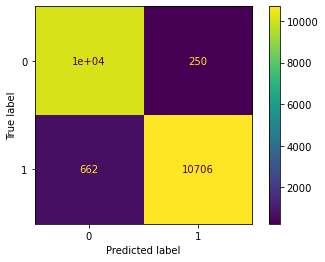

In [490]:
#Plotting confusion Matrix
from matplotlib.pyplot import figure
disp.plot()

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


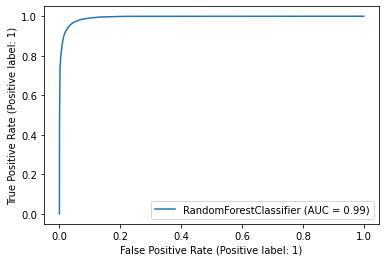

In [491]:
#Getting ROC Curve
metrics.plot_roc_curve(randomsearch_model, X_test, y_test) 

### Results

We have selected a model with below attributes:

- <b> Model Name : </b> Random Forest Classifier
- <b> Cost of Implemetation : </b> 134570.00
- <b> Recall Score : </b> 0.98
- <b> Precision Score : </b> 0.94
- <b> F1 Score : </b> 0.96

Thank you!!!